# A Numerical Experiment with a Wildfire Model's Autoignition Temperature

In [1]:
import numpy as np

import scipy.linalg # needed for matrix exponential
from scipy.optimize import curve_fit # for comparing numerics to theory later

import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo

import time

# Define some useful settings for plotting 
%config InlineBackend.figure_format='retina'
textcolor = 'k'
plt.rc('text', usetex=True) # Warning: this may need to be commented out if you don't have TeX, or if Jupyter
# can't find your TeX! 
plt.rc('font', family='serif')

In this notebook I present the code for reproducing a numerical experiment from my paper *Existence-Uniqueness Theory and Small-Data Decay for a Reaction-Diffusion Model of Wildfire Spread*. 

Important note: the mass fraction $Y(x,t)$ from the paper is called $S(x,t)$ here. Likewise, the parameter $\lambda$ is called $\mu$ here. 

The model PDEs are 

$$
\frac{\partial T}{\partial t} = \left(\Delta-\mu\right) T + Se^{-\frac{1}{T}}
$$

$$
\frac{\partial S}{\partial t} = -\beta Se^{-\frac{1}{T}}
$$

We use the spatial domain $x\in [-1,1]$ and enforce homogeneous Dirichlet boundary conditions on $T$ and $S$. Our experiment does not involve boundary effects, so this won't cause trouble when it comes to interpreting results. 

An additional caveat: the code is tailor-made for a specific purpose ("cold" initial data), and I do not vouch for the usefulness of my numerical method as a solver for the PDE system at hand given *arbitrary* initial data! Indeed, I think any pseudospectral method will have trouble with large initial data because the combustion fronts for this model are so sharp. 

In [2]:
# define parameters
k = 1. 
A = 1. 
B = 1. 
C = 0.
CS = 1.

tmax = 0.015 # time to run simulation up to

# Choose spatial resolution. 
N = 2**8 # spatial resolution 

In [3]:
# First, let's make sure we can resolve the Arrhenius reaction term properly... 
# it's smooth but not analytic! 

def arrhenius(T): 
    
    T = np.array(T) # technical step for handling inputs that are 
    # vanilla floats that don't live in an array
    
    out = np.zeros_like(T, dtype=float)
    
    eps0 = 1e-14
    
    out[T<eps0] = 0. 
        
    out[T>=eps0] = np.exp(-B/T[T>=eps0])
    
    return out

Our convention is that the state at time $t$ is denoted by 
$$
u(x,t)=(T(x,t), S(x,t))^{\mathrm{T}}
$$
When space is discretized into $N$ nodes, the discrete state $U$ at any given time is 
$$
U \in \mathbb{R}^{2\times N}. 
$$

In [4]:
# define initial states
def initial_state(x): 
        
    width = 0.03
    T0 = 1.*np.exp(-(x/width)**2)
    
    S0 = np.ones_like(x) 
    S0[np.abs(x)>0.75] = 0. 
    
    return np.array([T0, S0]) # output as a 2*length(x) array

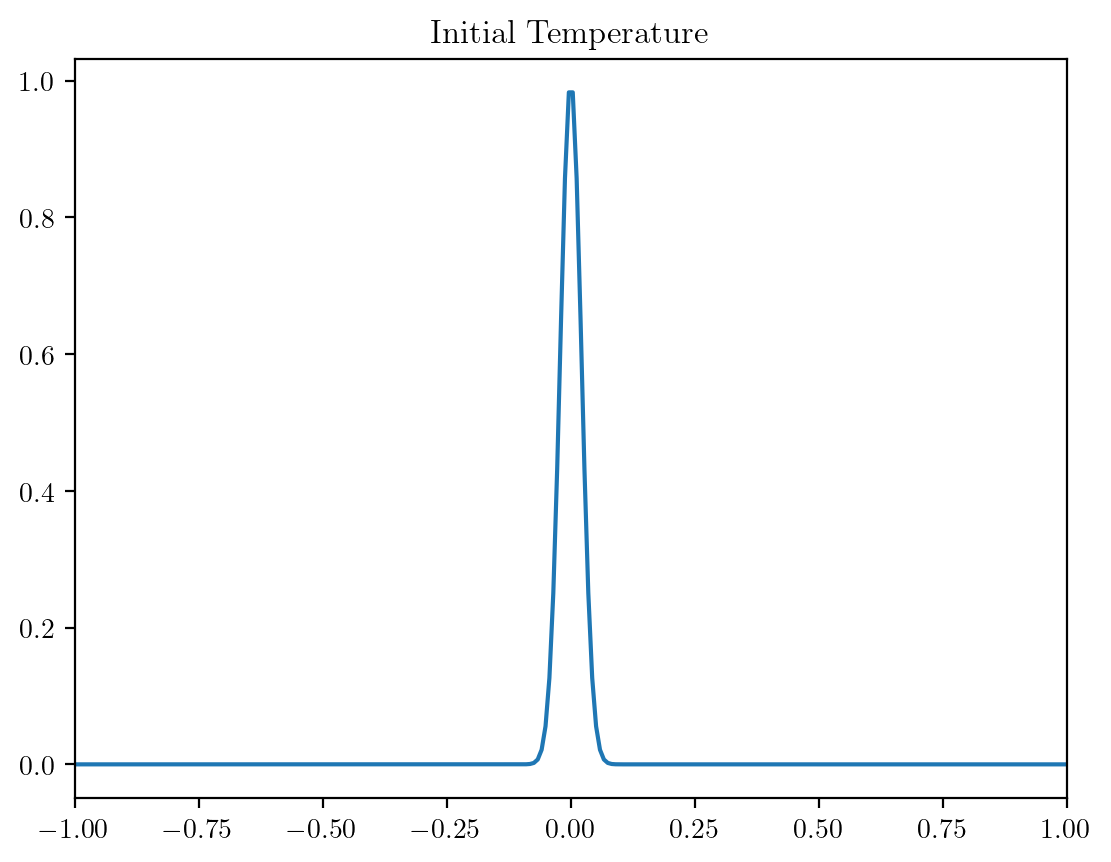

In [5]:
xx = np.linspace(-1,1, num=N, endpoint=True)
yy = initial_state(xx)[0]
plt.plot(xx,yy)
plt.title('Initial Temperature')
plt.xlim(-1,1)
plt.show()

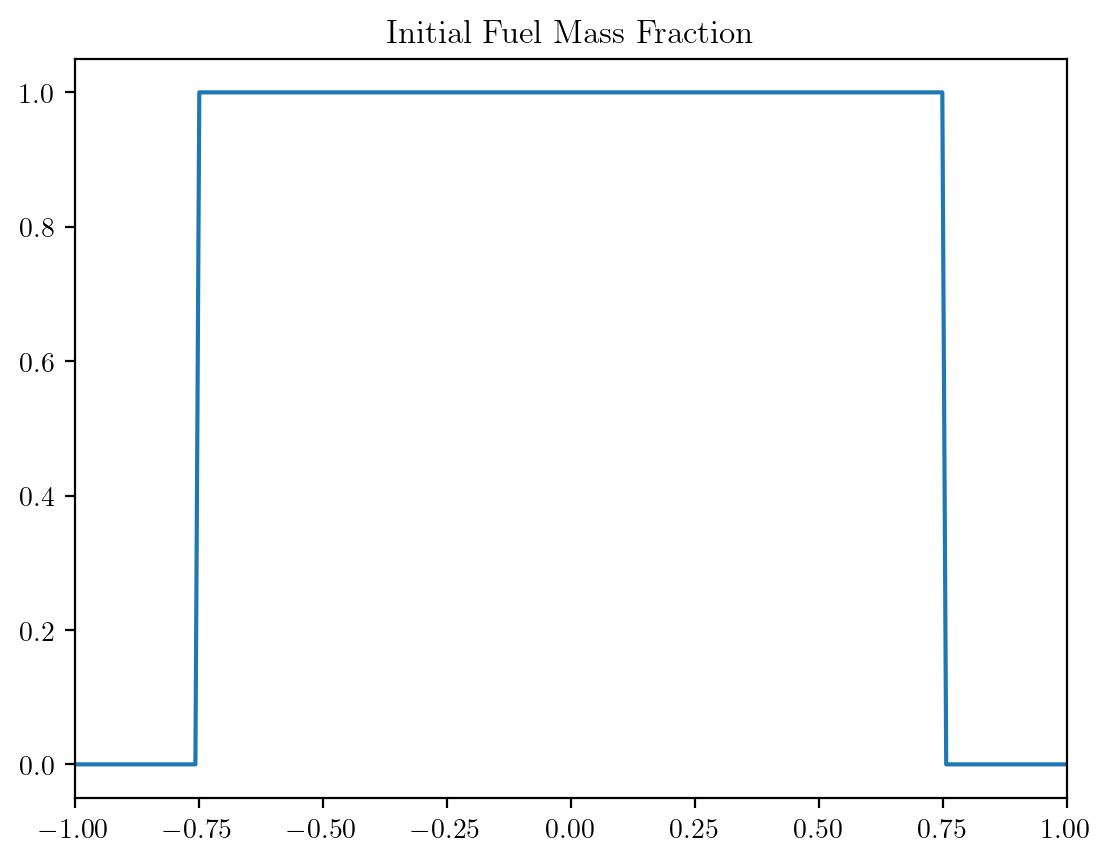

In [6]:
zz = initial_state(xx)[1]
plt.plot(xx,zz)
plt.title('Initial Fuel Mass Fraction')
plt.xlim(-1,1)
plt.show()

In [7]:
# forcing only important for temperature evolution 
def forcing(u):
        
    T, S = u[0,:], u[1,:]
        
    out = A*S*arrhenius(T)
    
    return out  

In [8]:
def chebnodes(N):
# spits out an array of the n^th Chebyshev nodes in [-1,1]. NOTE: the output is arranged so 
# x[-1] = -1, x[0]=1. In other words, the grid is presented right-to-left instead.
# This is consistent with the convention in Trefethen's book (ref. [21] in the paper)

    theta = (np.pi/(N))*np.arange(0,N+1, dtype=int)
    
    x = np.cos(theta)
    
    return x

def chebdiff(N):
# spits out N+1 x N+1 Chebyshev differentiation matrix 

    c = np.ones([N+1,1])
    
    c[0] = 2.
    
    c[-1] = 2. 
    
    c = (c*(-1)**np.arange(0,N+1)).T
    
    x = chebnodes(N)
        
    X = np.tile(x,[N+1,1])
    
    dX = X - X.T
        
    D = c*(1./c.T)/(dX + np.identity(N+1))
        
    D -= np.diag(np.sum(D.T, axis=1))
    
    return D.T

In [9]:
start = time.time()
x = chebnodes(N)

D = chebdiff(N)
D2 = np.linalg.matrix_power(D,2)[1:N, 1:N] # square D, then kill the non-contributing bdry pieces.

In [10]:
dt = 1e-4 # time step size

nsteps = int(tmax/dt) # total num of time steps we take

In [11]:
matA = k*D2 - A*C*np.eye(N-1) # matrix we need to deal with frequently, discretized linear (diffusive) part of PDE

# define approximate linear propagator over a time step
propagator = scipy.linalg.expm(dt*matA)

# now figure out the phi1-function for ETD Euler by solving a matrix equation (directly)
phi1 = scipy.linalg.solve(matA, propagator-np.eye(N-1))

In [12]:
ndump = 1

uinit = initial_state(x)

uold = uinit[:,1:N] # only propagate interior pieces... implicit from Dirichlet BCs!

Told = uold[0,:]

Sold = uold[1,:]

# make data storage array
udata = np.zeros([2, int(nsteps/ndump), N+1], dtype=float)
udata[:,0,:] = uinit

cnt = 0. # counter 

for n in np.arange(1,nsteps): 
    
    f = forcing(uold)
    
    # step temperature forward 
    Tnew = Told + phi1 @ (matA@Told + f)
    
    # step the fuel density forward, w/ vanilla forward Euler for now
    Snew = Sold*(1. - CS*dt*arrhenius(Told))
        
    # [this is where more physical BCs would be enforced!] 
    
    Told = Tnew
    
    Sold = Snew
    
    cnt+=1
    
    if cnt%ndump == 0: 
        
        uold = np.array([Told, Sold])
        
        udata[:,int(n/ndump),1:N] = uold 
        
    else: 
        
        pass
        
end = time.time()

In [13]:
runtime=end-start
print('Simulation runtime = %.3f' %runtime,'s' )

Simulation runtime = 0.196 s


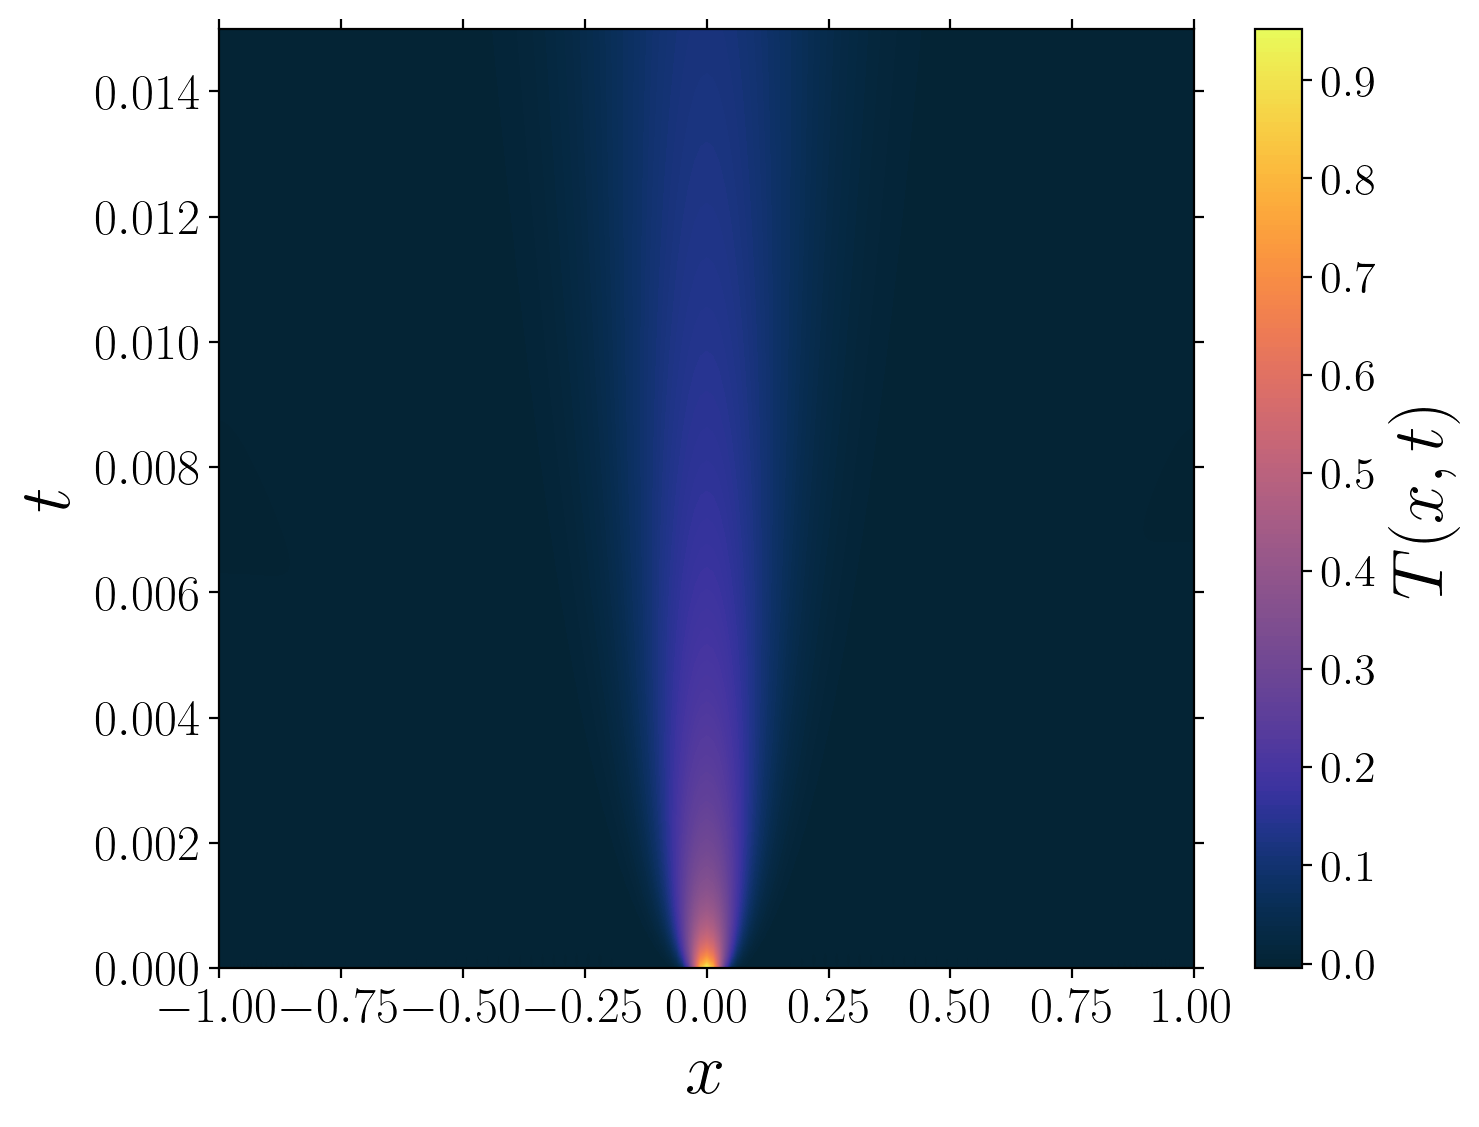

In [14]:
# MAKE FILLED CONTOUR PLOT OF SOLN
fig = plt.figure()

times = np.linspace(0., tmax, num=int(nsteps/ndump), endpoint=True)

CF = plt.contourf(x,times,udata[0,:,:], levels=200, cmap = cmo.thermal)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = textcolor)
plt.ylabel(r"$t$", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=18, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=18, rotation=0, color = textcolor)

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color=textcolor) 
#plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$T(x,t)$', fontsize=26, color=textcolor)

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
figname = 'mandel_autoignition_sim.png'
plt.savefig(figname, dpi=600)

plt.show()

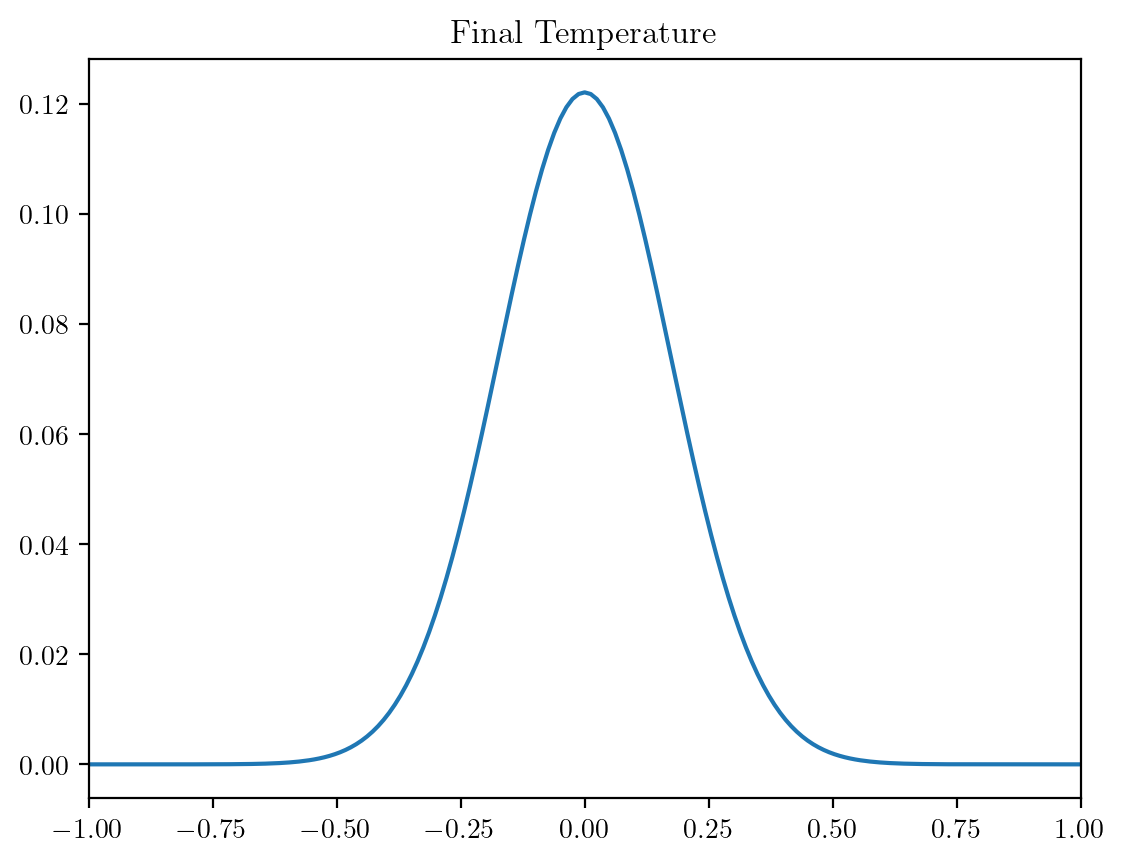

In [15]:
plt.plot(x, udata[0,-1,:])
plt.title('Final Temperature')
plt.xlim(-1,1)
plt.show()

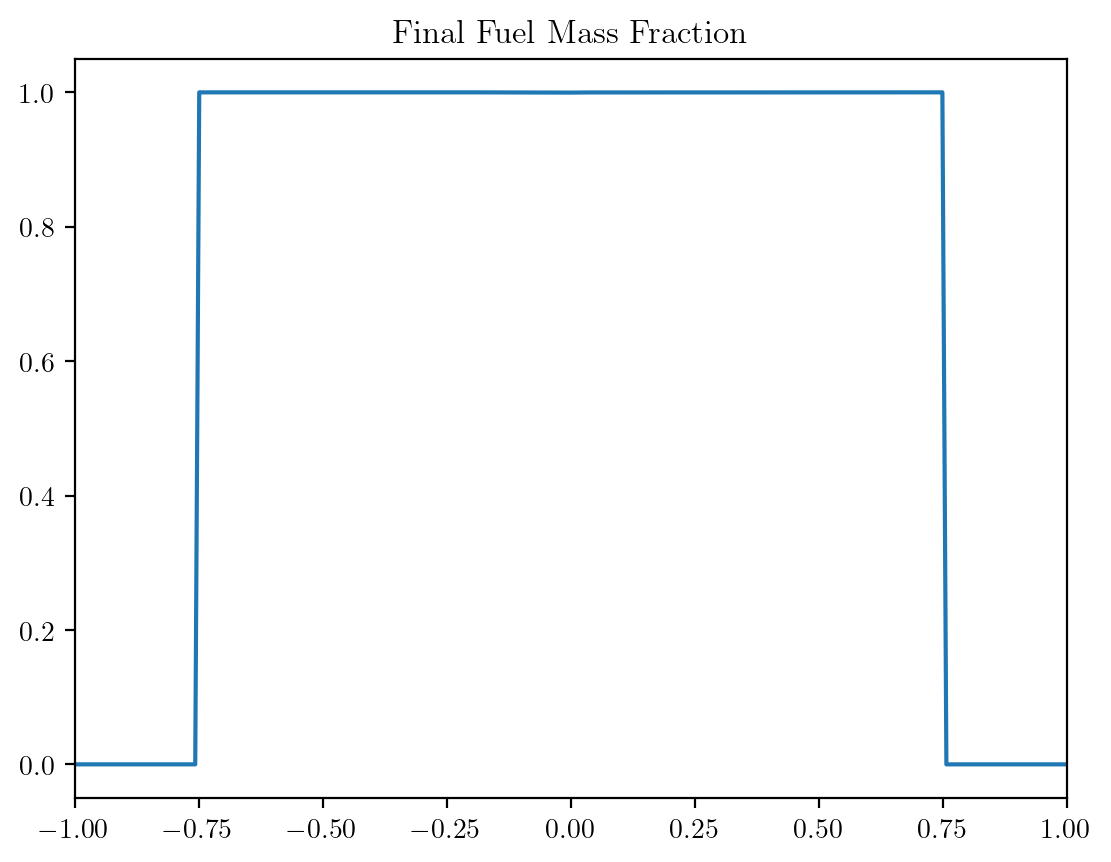

In [16]:
plt.plot(x, udata[1,-1,:])
plt.title('Final Fuel Mass Fraction')
plt.xlim(-1,1)
plt.show()

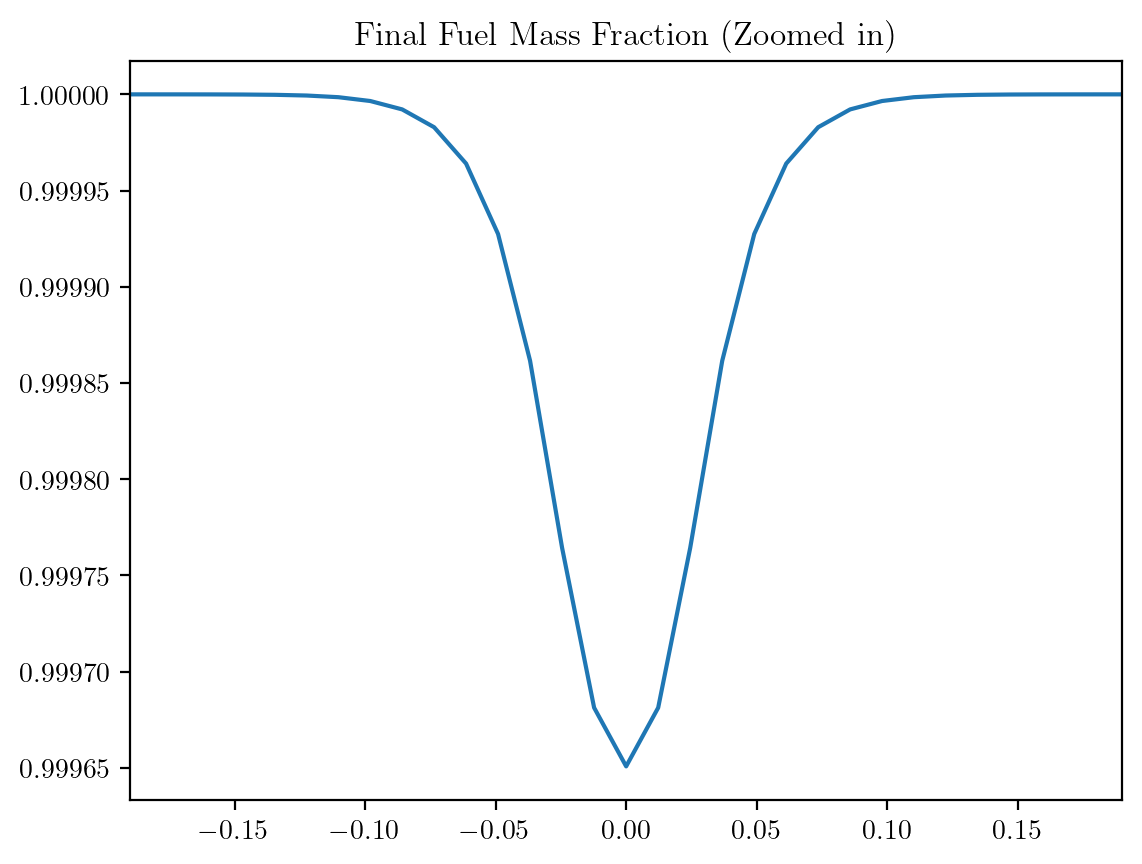

In [17]:
plt.plot(x[np.abs(x)<0.2], udata[1,-1,:][np.abs(x)<0.2])
plt.title('Final Fuel Mass Fraction (Zoomed in)')
plt.xlim(-.19,.19)
plt.show()

Indeed, we see that the fuel mass fraction is barely affected by the initial heat! 

Finally, we fit a function of the form 

$$ 
A(t; a) = (1+at)^{-\frac12}
$$

to the (time-decaying) $L^{\infty}_{x}$ norm our temperature $T(x,t)$ to see how well the analysis reflects the behaviour of our solution. 

This fit is accomplished using nonlinear least-squares, as implemented in [SciPy's `curve_fit` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). 

In [76]:
# To avoid cluttering the pictures, we take as "training data" only every third amplitude value
times_train = times[::3]
amplitudes_train = np.amax(udata[0, ::3, :], axis=-1)

def amplitude_model(t, a):
    return (a*t + np.ones_like(t))**-0.5

a_best = curve_fit(amplitude_model, times_train, amplitudes_train)[0]
print('a_best = %.4e' % a_best[0])
amplitudes_empirical = amplitude_model(times, a_best)
t_best = 1./a_best[0]
print('t_best = %.4e' % t_best)

a_best = 4.4110e+03
t_best = 2.2671e-04


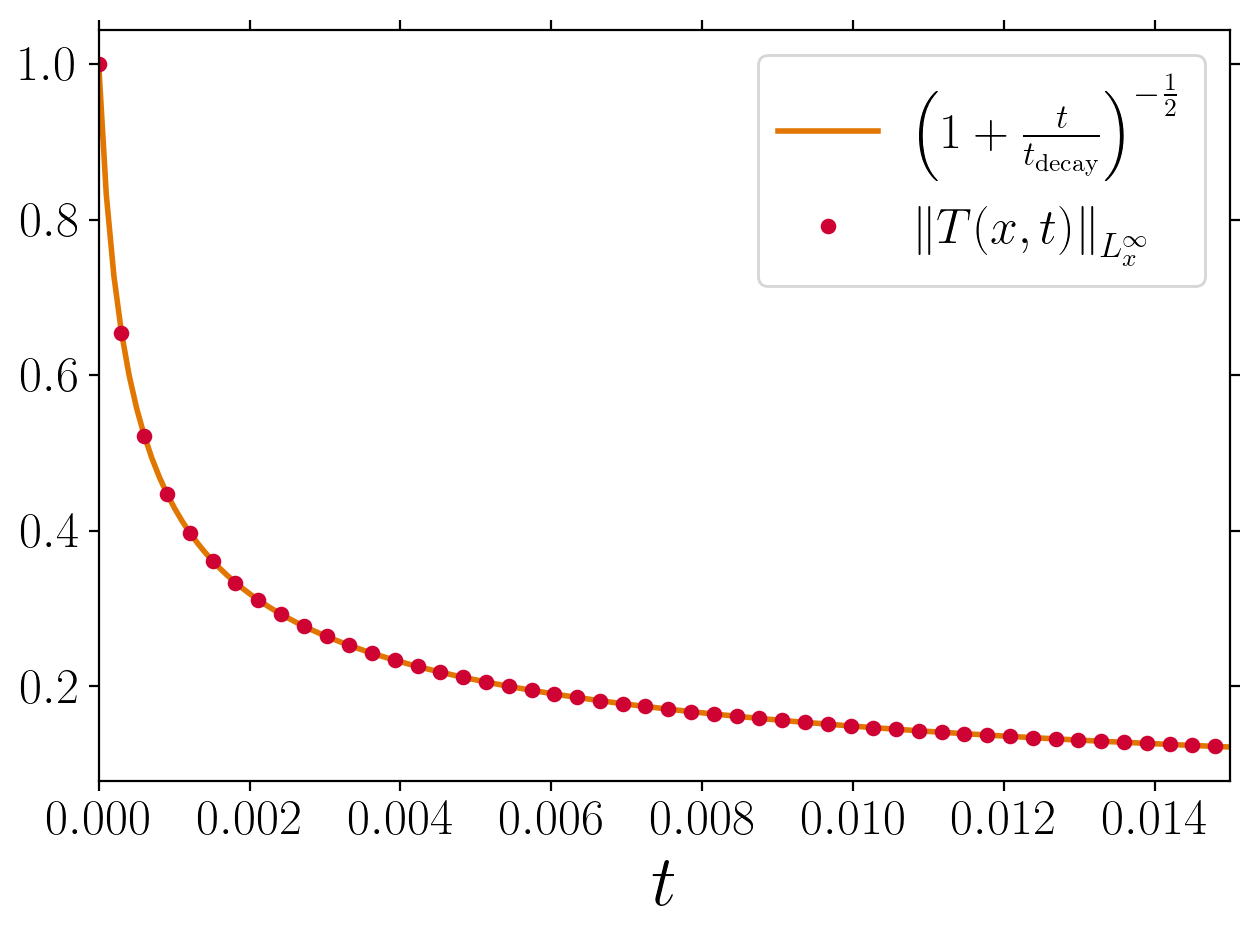

In [75]:
plt.plot(times, 
         amplitudes_empirical, 
         color='xkcd:pumpkin', 
         linestyle='solid', 
         linewidth='2',
         label=r'$\left(1+\frac{t}{t_{\mathrm{decay}}}\right)^{-\frac12}$',
)

plt.plot(times_train, 
         amplitudes, 
         'o',
         color='xkcd:cherry',  
         markersize=4.6,
         label=r'$\left\|T(x,t)\right\|_{L^{\infty}_{x}}$',
)

plt.xlim(0, tmax)
plt.legend(fontsize=18)

plt.xlabel(r"$t$", fontsize=26, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=18, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=18, rotation=0, color = textcolor)

plt.tight_layout()
fig.set_size_inches(8, 6) 

figname = 'mandel_autoignition_bound.png'
plt.savefig(figname, dpi=600)

plt.show()

Notice how we have traded $a$ for $t_{\mathrm{decay}}\doteq a^{-1}$ in the label: with this re-definition, we can view $t_{\mathrm{decay}}$ as a decay timescale for $\left\|T(x,t)\right\|_{L^\infty_x}$. 